In [19]:
import numpy as np
import pandas as pd

import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 2020

N_FOLD = 5

In [3]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            #.dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})

In [4]:
loading

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11749,21750,0.005996,0.003873,0.012353,0.000242,-0.002159,0.020201,0.020931,0.003684,-0.002458,...,0.011454,0.022840,0.006448,-0.007203,0.029689,0.004942,0.007751,-0.020226,0.028821,0.017492
11750,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439
11751,21752,0.000627,0.011407,0.010957,0.000534,-0.000347,0.013499,0.010541,0.001867,0.007447,...,0.012055,0.020741,0.001160,-0.007140,0.025236,0.002026,0.001876,-0.014612,0.021665,0.019592
11752,21753,0.007431,0.021419,0.014143,-0.005623,-0.006399,0.008602,0.006831,-0.001018,0.014972,...,0.019220,0.026282,0.020715,-0.008130,0.025149,0.007695,0.003226,-0.003505,0.029326,0.014235


In [5]:
tfd_path = '/media/hiroki/working/kaggle/trends-neuroimaging/tf_data/ica'
loading_ic = pd.read_csv(tfd_path+'/loading_ica.csv', dtype={'Id':str})

In [6]:
loading_ic

,Id,loading_ic0,loading_ic1,loading_ic2,loading_ic3,loading_ic4,loading_ic5,loading_ic6,loading_ic7,loading_ic8,...,loading_ic16,loading_ic17,loading_ic18,loading_ic19,loading_ic20,loading_ic21,loading_ic22,loading_ic23,loading_ic24,loading_ic25
0,10001,0.013881,0.006434,-0.017351,-0.001350,-0.026765,-0.009015,-0.000128,0.017085,0.004339,...,0.016566,0.000725,-0.016200,-0.008589,0.006724,0.011059,-0.007257,-0.001703,-0.002508,0.016876
1,10002,0.014648,-0.002819,0.009043,0.005117,-0.008964,-0.014314,-0.005157,0.011966,0.009154,...,-0.002972,-0.004058,-0.003185,0.002225,-0.000101,0.003700,0.005778,-0.003805,0.007618,0.004650
2,10003,-0.009894,-0.007611,-0.000260,-0.001841,-0.017320,-0.019926,0.024015,0.008714,0.005036,...,-0.002851,0.016404,-0.008111,-0.018997,-0.007095,0.008833,0.015139,0.003438,-0.005879,0.005180
3,10004,-0.004283,-0.011491,-0.009284,0.002350,0.000555,0.005292,-0.009456,0.010366,-0.004393,...,0.005701,0.010280,0.001409,0.002730,-0.000869,0.011371,-0.003844,0.004540,0.012158,-0.012679
4,10005,-0.005909,-0.006240,-0.012665,-0.007625,0.004713,-0.000149,0.000317,0.003704,0.020257,...,0.010395,-0.002336,0.008993,0.005642,0.003106,0.006424,0.004936,-0.006911,-0.003169,0.002617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11749,21750,-0.023170,-0.013858,-0.000911,-0.000571,-0.006309,0.002357,0.000424,-0.002414,-0.002035,...,0.004233,-0.005596,-0.001070,-0.008748,-0.020641,0.000137,0.007897,0.003656,0.007056,-0.002283
11750,21751,0.010635,0.011622,0.005867,0.003775,-0.002361,-0.005365,0.002279,0.001806,-0.003262,...,-0.022059,-0.013908,0.008533,0.013208,0.015854,0.000336,0.003683,-0.021729,0.006740,-0.008175
11751,21752,0.004094,-0.000567,-0.012673,0.002947,0.006248,-0.016227,-0.002531,-0.005835,0.011058,...,0.005554,-0.003142,0.007984,-0.000626,0.013734,0.004141,-0.013882,-0.008546,0.011906,0.002748
11752,21753,0.008198,0.021104,0.003856,-0.005691,-0.007533,-0.007307,0.017035,-0.000567,-0.003184,...,-0.013836,0.009594,-0.011883,0.010484,-0.014092,0.003821,-0.010777,-0.019572,0.003470,0.000228


In [7]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading_ic.columns[1:])

In [8]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [9]:
# merge
train = train.merge(loading_ic, on=ID, how='left')
#train = train.merge(fnc, on=ID, how='left')
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,loading_ic0,loading_ic1,loading_ic2,loading_ic3,...,loading_ic16,loading_ic17,loading_ic18,loading_ic19,loading_ic20,loading_ic21,loading_ic22,loading_ic23,loading_ic24,loading_ic25
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.013881,0.006434,-0.017351,-0.001350,...,0.016566,0.000725,-0.016200,-0.008589,0.006724,0.011059,-0.007257,-0.001703,-0.002508,0.016876
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.014648,-0.002819,0.009043,0.005117,...,-0.002972,-0.004058,-0.003185,0.002225,-0.000101,0.003700,0.005778,-0.003805,0.007618,0.004650
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,-0.004283,-0.011491,-0.009284,0.002350,...,0.005701,0.010280,0.001409,0.002730,-0.000869,0.011371,-0.003844,0.004540,0.012158,-0.012679
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.005909,-0.006240,-0.012665,-0.007625,...,0.010395,-0.002336,0.008993,0.005642,0.003106,0.006424,0.004936,-0.006911,-0.003169,0.002617
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.003208,0.011158,0.011029,-0.004304,...,0.001748,-0.008319,0.001509,0.000827,-0.011359,-0.002660,0.013682,-0.006269,-0.003414,-0.003206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.010214,0.000727,0.003668,-0.005712,...,-0.007860,-0.001217,0.006112,-0.000755,0.008882,0.008366,-0.000982,-0.001477,0.005993,-0.007777
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,-0.005092,-0.001358,-0.005187,-0.000030,...,-0.004026,0.007405,-0.017764,-0.005815,-0.008955,0.012329,0.002522,-0.011327,0.010727,0.022240
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,-0.023170,-0.013858,-0.000911,-0.000571,...,0.004233,-0.005596,-0.001070,-0.008748,-0.020641,0.000137,0.007897,0.003656,0.007056,-0.002283
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.004094,-0.000567,-0.012673,0.002947,...,0.005554,-0.003142,0.007984,-0.000626,0.013734,0.004141,-0.013882,-0.008546,0.011906,0.002748


In [10]:
# merge
test = test.merge(loading_ic, on=ID, how='left')
#test = test.merge(fnc, on=ID, how='left')
test

,Id,loading_ic0,loading_ic1,loading_ic2,loading_ic3,loading_ic4,loading_ic5,loading_ic6,loading_ic7,loading_ic8,...,loading_ic16,loading_ic17,loading_ic18,loading_ic19,loading_ic20,loading_ic21,loading_ic22,loading_ic23,loading_ic24,loading_ic25
0,10003,-0.009894,-0.007611,-0.000260,-0.001841,-0.017320,-0.019926,0.024015,0.008714,0.005036,...,-0.002851,0.016404,-0.008111,-0.018997,-0.007095,0.008833,0.015139,0.003438,-0.005879,0.005180
1,10006,0.004949,-0.013667,-0.004869,-0.022803,0.006712,0.007252,0.014445,0.006420,0.004933,...,-0.000161,0.002704,-0.002085,-0.009003,0.010163,-0.014106,-0.007612,0.017612,-0.004470,-0.002200
2,10010,-0.006899,-0.002462,0.008805,0.001662,0.010357,-0.007177,-0.008555,0.012579,-0.007977,...,-0.004310,0.016080,-0.002954,0.004944,0.004899,0.004551,-0.008190,0.010132,-0.005311,-0.011707
3,10011,0.000051,0.002092,-0.005104,0.004447,-0.010604,0.007688,-0.000659,-0.010881,0.005204,...,-0.020111,-0.003926,-0.001493,-0.002571,0.007843,-0.011606,-0.014469,0.009687,-0.000039,0.002556
4,10012,-0.005089,-0.007242,0.005328,-0.030246,-0.011191,-0.006631,-0.005743,-0.003304,0.012790,...,0.006849,0.022440,0.010307,0.002278,0.003556,-0.022208,0.015129,0.016984,0.011608,-0.005853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21745,-0.002399,0.001534,0.005335,-0.009163,-0.002450,0.005337,0.004113,-0.010702,-0.006212,...,-0.003359,0.009611,0.010569,-0.009972,-0.011444,-0.005711,0.001752,-0.000364,-0.005495,-0.012466
5873,21748,0.006720,-0.021968,0.008122,0.000484,0.004582,-0.003596,-0.001520,-0.007899,0.016845,...,0.000557,-0.013125,-0.004780,-0.010561,0.003093,0.013196,-0.009773,-0.003721,-0.012953,-0.007318
5874,21749,-0.003498,0.015216,0.001591,0.007734,0.007083,0.000735,-0.006211,-0.012996,-0.002442,...,-0.006445,0.002731,-0.029000,0.010169,-0.001830,0.002215,0.003807,0.006275,-0.005449,0.006811
5875,21751,0.010635,0.011622,0.005867,0.003775,-0.002361,-0.005365,0.002279,0.001806,-0.003262,...,-0.022059,-0.013908,0.008533,0.013208,0.015854,0.000336,0.003683,-0.021729,0.006740,-0.008175


In [11]:
import IPython

def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [12]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [13]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def gpr_predict_cv(train_x, train_y, test_x, model, target_name):
    preds = []
    preds_std = []
    
    preds_test = []
    preds_test_std = []
    
    va_idxes = []
    
    score = []
    mae = []
    rmse = []

    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        print("FOLD:{}".format(i+1))
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        # autoscaling
        autoscaled_train_x = (tr_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        autoscaled_train_y = (tr_y - tr_y.mean()) / tr_y.std(ddof=1)
        autoscaled_val_x = (va_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        autoscaled_test_x = (test_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        
        model.fit(autoscaled_train_x, autoscaled_train_y)
        # pred_val
        pred, pred_std = model.predict(autoscaled_val_x, return_std=True)
        pred = pred * tr_y.std(ddof=1) + tr_y.mean()
        preds.append(pred)
        # pred_val_std
        pred_std = pred_std * tr_y.std(ddof=1)
        preds_std.append(pred_std)
        # append valid idx
        va_idxes.append(va_idx)
        # pred_test
        pred_test, pred_test_std = model.predict(autoscaled_test_x, return_std=True)
        pred_test = pred_test * tr_y.std(ddof=1) + tr_y.mean()
        preds_test.append(pred_test)
        # pred_test_std
        pred_test_std = pred_test_std * tr_y.std(ddof=1)
        preds_test_std.append(pred_test_std)
        
        # calc score
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    preds_std = np.concatenate(preds_std, axis=0)
    
    order = np.argsort(va_idxes)
    
    pred_train = preds[order]
    pred_std_train = preds_std[order]

    # テストデータに対する予測値の平均をとる
    pred_test = np.mean(preds_test, axis=0)
    pred_test_std = np.mean(preds_test_std, axis=0)

    return pred_train, pred_std_train, pred_test, pred_test_std, score_cv

# Modeling

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
#from sklearn.model_selection import train_test_split, GridSearchCV

In [15]:
#ConstantKernel() * RBF(np.ones(x_train.shape[1])) + WhiteKernel(),
#ConstantKernel() * RBF(np.ones(x_train.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),

In [16]:
kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

In [17]:
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,loading_ic0,loading_ic1,loading_ic2,loading_ic3,...,loading_ic16,loading_ic17,loading_ic18,loading_ic19,loading_ic20,loading_ic21,loading_ic22,loading_ic23,loading_ic24,loading_ic25
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.013881,0.006434,-0.017351,-0.001350,...,0.016566,0.000725,-0.016200,-0.008589,0.006724,0.011059,-0.007257,-0.001703,-0.002508,0.016876
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.014648,-0.002819,0.009043,0.005117,...,-0.002972,-0.004058,-0.003185,0.002225,-0.000101,0.003700,0.005778,-0.003805,0.007618,0.004650
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,-0.004283,-0.011491,-0.009284,0.002350,...,0.005701,0.010280,0.001409,0.002730,-0.000869,0.011371,-0.003844,0.004540,0.012158,-0.012679
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.005909,-0.006240,-0.012665,-0.007625,...,0.010395,-0.002336,0.008993,0.005642,0.003106,0.006424,0.004936,-0.006911,-0.003169,0.002617
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.003208,0.011158,0.011029,-0.004304,...,0.001748,-0.008319,0.001509,0.000827,-0.011359,-0.002660,0.013682,-0.006269,-0.003414,-0.003206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.010214,0.000727,0.003668,-0.005712,...,-0.007860,-0.001217,0.006112,-0.000755,0.008882,0.008366,-0.000982,-0.001477,0.005993,-0.007777
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,-0.005092,-0.001358,-0.005187,-0.000030,...,-0.004026,0.007405,-0.017764,-0.005815,-0.008955,0.012329,0.002522,-0.011327,0.010727,0.022240
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,-0.023170,-0.013858,-0.000911,-0.000571,...,0.004233,-0.005596,-0.001070,-0.008748,-0.020641,0.000137,0.007897,0.003656,0.007056,-0.002283
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.004094,-0.000567,-0.012673,0.002947,...,0.005554,-0.003142,0.007984,-0.000626,0.013734,0.004141,-0.013882,-0.008546,0.011906,0.002748


In [20]:
%%time
#pred_train_targets_gpr = {}
#pred_test_targets_gpr = {}

pred_train_targets_gpr_dfs = {}
pred_train_targets_std_gpr_dfs = {}

pred_test_targets_gpr_dfs = {}
pred_test_targets_std_gpr_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    
    train_df = train[train[target].notnull()]
    test_df = test
    
    # define data
    use_idx = train_df.index
    train_x = train_df.drop([ID]+TARGET_COLS, axis=1)
    train_y = train_df[target]
    test_x = test_df.drop(ID, axis=1)
    
    model = GaussianProcessRegressor(kernels[2], alpha=0)
    
    print("-----{}-----".format(target))
    pred_train, pred_std_train, pred_test, pred_std_test, score_cv = gpr_predict_cv(train_x=train_x,
                                                                                    train_y=train_y,
                                                                                    test_x=test_x,
                                                                                    model=model,
                                                                                    target_name=target)
    overal_score += w*score_cv
    # make pred_train_df
    pred_train_targets_gpr_dfs[target] = pd.Series(pred_train, name="pre_gpr_{}".format(target), index=use_idx)
    pred_train_targets_gpr_dfs[target] = pd.merge(train['Id'],
                                                 pred_train_targets_gpr_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    # make pred_train_std_df
    pred_train_targets_std_gpr_dfs[target] = pd.Series(pred_std_train, name="pre_gpr_std_{}".format(target), index=use_idx)
    pred_train_targets_std_gpr_dfs[target] = pd.merge(train['Id'],
                                                      pred_train_targets_std_gpr_dfs[target],
                                                      left_index=True,
                                                      right_index=True)
    # make pred_test_df
    pred_test_targets_gpr_dfs[target] = pd.Series(pred_test, name="pre_gpr_{}".format(target))
    pred_test_targets_gpr_dfs[target] = pd.concat([test['Id'], pred_test_targets_gpr_dfs[target]], axis=1)
    # make pred_test_std_df
    pred_test_targets_std_gpr_dfs[target] = pd.Series(pred_std_test, name="pre_gpr_std_{}".format(target))
    pred_test_targets_std_gpr_dfs[target] = pd.concat([test['Id'], pred_test_targets_std_gpr_dfs[target]], axis=1)
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:5
-----age-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
age_score:0.15357333
age_mae:7.683637883974268
age_rmse:9.728727920430845
-----domain1_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain1_var1_score:0.15182075
domain1_var1_mae:7.815389913426325
domain1_var1_rmse:9.738902972414644
-----domain1_var2-----
FOLD:1
FOLD:2
FOLD:3


KeyboardInterrupt: 

In [ ]:
kernel=1
N_FOLD:5
-----age-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
age_score:0.15356026
age_mae:7.682990432680187
age_rmse:9.738066673270678
-----domain1_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain1_var1_score:0.15187637
domain1_var1_mae:7.818257861417544
domain1_var1_rmse:9.741495496203143
-----domain1_var2-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain1_var2_score:0.15136873
domain1_var2_mae:8.967204182656236
domain1_var2_rmse:11.389622768872112
-----domain2_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain2_var1_score:0.18261342
domain2_var1_mae:8.639908276699787
domain2_var1_rmse:10.929079670762658
-----domain2_var2-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain2_var2_score:0.17793683
domain2_var2_mae:9.234801728704339
domain2_var2_rmse:11.761475705825383
--------------------------------------------
Overal score: 0.16223226
CPU times: user 2h 28s, sys: 5min 39s, total: 2h 6min 7s
Wall time: 54min 56s

kernel=0
N_FOLD:5
-----age-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
age_score:0.15409244
age_mae:7.709647187791907
age_rmse:9.774723633353334
-----domain1_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain1_var1_score:0.15182075
domain1_var1_mae:7.815389687533996
domain1_var1_rmse:9.738902227644516
-----domain1_var2-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain1_var2_score:0.15125287
domain1_var2_mae:8.960295491923217
domain1_var2_rmse:11.376382150904778
-----domain2_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain2_var1_score:0.18269695
domain2_var1_mae:8.643846369536508
domain2_var1_rmse:10.928373724543942
-----domain2_var2-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
domain2_var2_score:0.17771718
domain2_var2_mae:9.223387786996469
domain2_var2_rmse:11.759045043383235
--------------------------------------------
Overal score: 0.16233809

In [19]:
for i, pred_df in enumerate(pred_train_targets_gpr_dfs.values()):
    if i == 0:
        pred_train_dfs = pred_df
    else:
        pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [20]:
for i, pred_df in enumerate(pred_train_targets_std_gpr_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [21]:
for i, pred_df in enumerate(pred_test_targets_gpr_dfs.values()):
    if i == 0:
        pred_test_dfs = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

In [22]:
for i, pred_df in enumerate(pred_test_targets_std_gpr_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [26]:
#pred_train_dfs.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_ICA/gpr_train.csv', index=False)
#pred_test_dfs.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_ICA/gpr_test.csv', index=False)

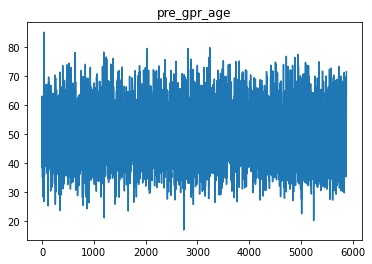

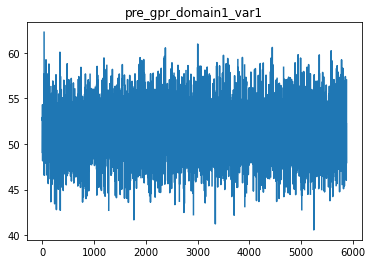

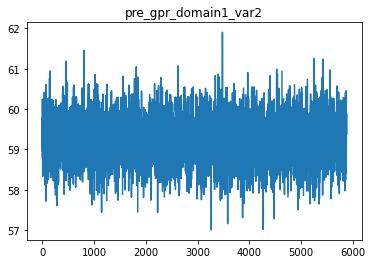

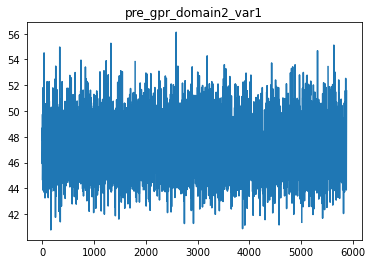

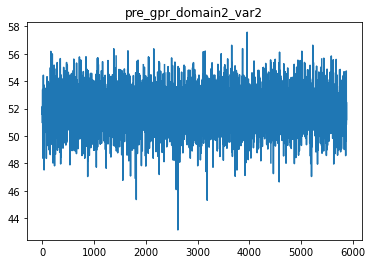

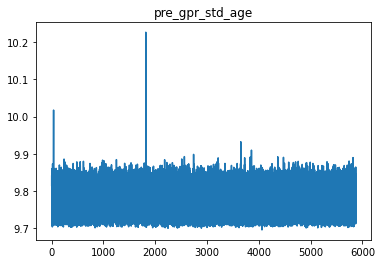

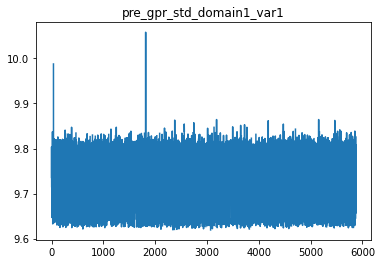

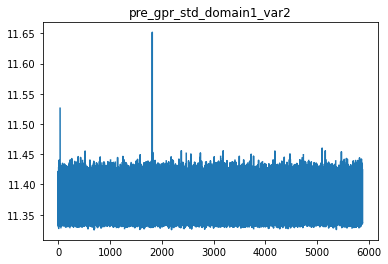

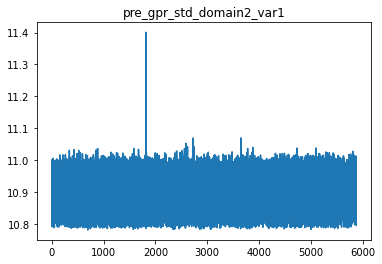

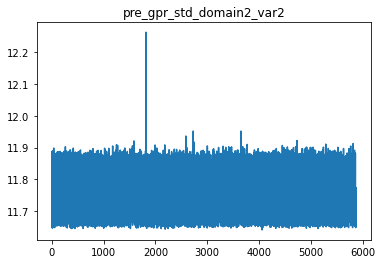

In [24]:
for col in pred_train_dfs.drop('Id', axis=1).columns:
    plt.plot(pred_train_dfs[col])
    plt.title(col)
    plt.show()

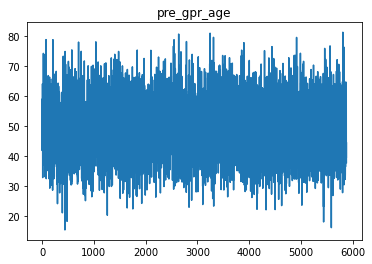

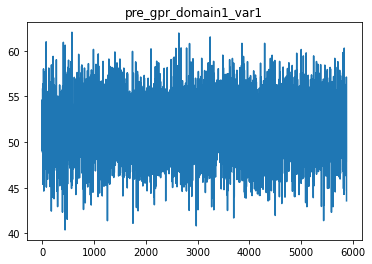

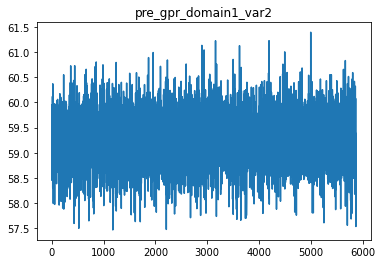

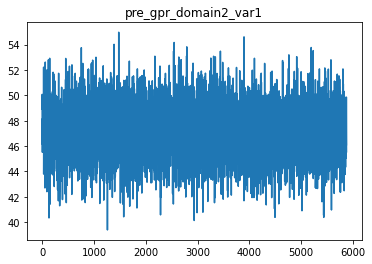

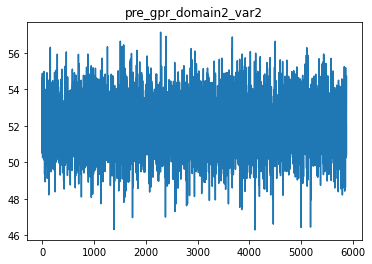

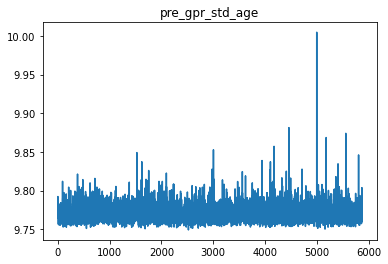

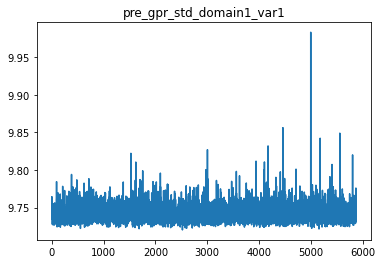

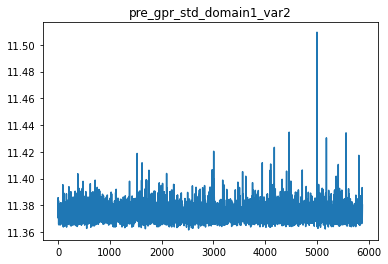

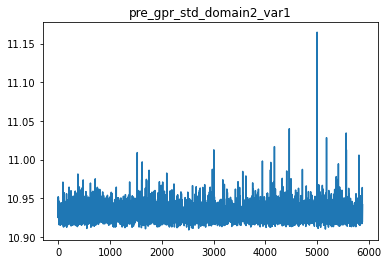

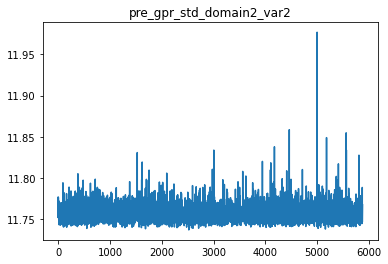

In [25]:
for col in pred_test_dfs.drop('Id', axis=1).columns:
    plt.plot(pred_test_dfs[col])
    plt.title(col)
    plt.show()